In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
# 1 represents real, 0 fake
df['label'] = 1

In [5]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [6]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


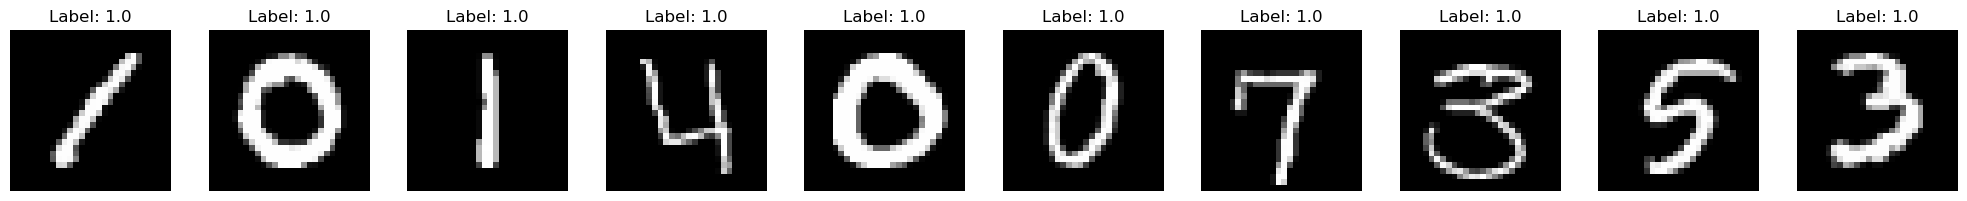

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = torch.tensor(X_discriminator).float() / 255.0

In [9]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = F.sigmoid(self.convT5(x))
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
# scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|█████████████████████████████████████████████████████| 657/657 [00:20<00:00, 32.60it/s, loss_D=1.45, loss_G=0.536]


Epoch [1/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [1/100] - Average D loss: 1.2530, Average G loss: 0.8599


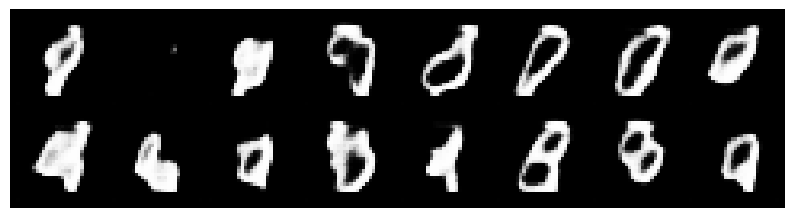

100%|██████████████████████████████████████████████████████| 657/657 [00:19<00:00, 33.48it/s, loss_D=1.41, loss_G=1.08]


Epoch [2/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [2/100] - Average D loss: 1.2665, Average G loss: 0.8849


100%|█████████████████████████████████████████████████████| 657/657 [00:34<00:00, 19.10it/s, loss_D=1.03, loss_G=0.809]


Epoch [3/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [3/100] - Average D loss: 1.1389, Average G loss: 1.0191


100%|██████████████████████████████████████████████████████| 657/657 [01:09<00:00,  9.51it/s, loss_D=1.02, loss_G=1.02]


Epoch [4/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [4/100] - Average D loss: 1.0801, Average G loss: 1.0773


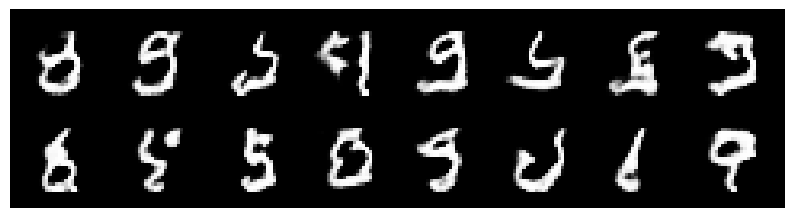

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.898, loss_G=1.54]


Epoch [5/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [5/100] - Average D loss: 1.0830, Average G loss: 1.0768


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.848, loss_G=1.48]


Epoch [6/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [6/100] - Average D loss: 1.0146, Average G loss: 1.1801


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=1.07, loss_G=1.26]


Epoch [7/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [7/100] - Average D loss: 0.9339, Average G loss: 1.3109


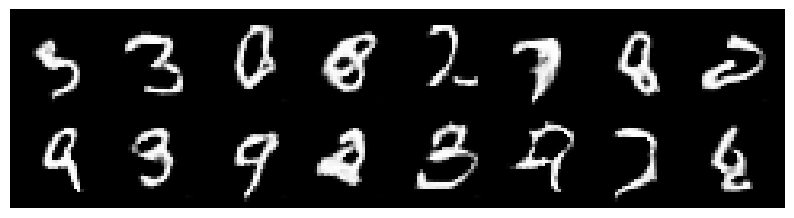

100%|███████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=1.06, loss_G=1.5]


Epoch [8/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [8/100] - Average D loss: 0.9110, Average G loss: 1.3801


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.79, loss_G=2.01]


Epoch [9/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [9/100] - Average D loss: 0.8696, Average G loss: 1.4727


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.887, loss_G=1.1]


Epoch [10/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [10/100] - Average D loss: 0.8301, Average G loss: 1.5743


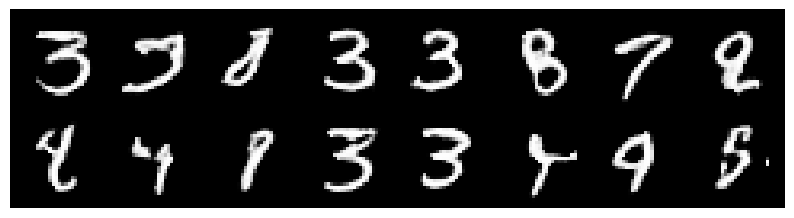

100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.891, loss_G=1.1]


Epoch [11/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [11/100] - Average D loss: 0.7907, Average G loss: 1.6473


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.619, loss_G=1.28]


Epoch [12/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [12/100] - Average D loss: 0.7830, Average G loss: 1.6836


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.826, loss_G=1.73]


Epoch [13/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [13/100] - Average D loss: 0.7774, Average G loss: 1.7140


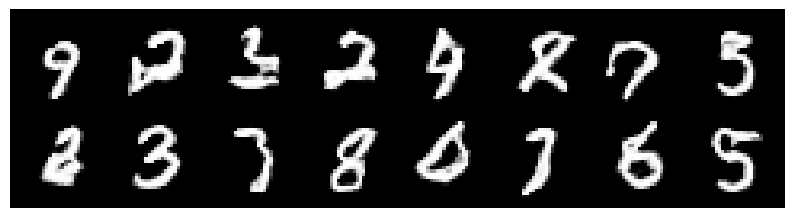

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.817, loss_G=1.63]


Epoch [14/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [14/100] - Average D loss: 0.7659, Average G loss: 1.7367


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.958, loss_G=1.29]


Epoch [15/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [15/100] - Average D loss: 0.7546, Average G loss: 1.7822


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.818, loss_G=2.29]

Epoch [16/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [16/100] - Average D loss: 0.7371, Average G loss: 1.8231


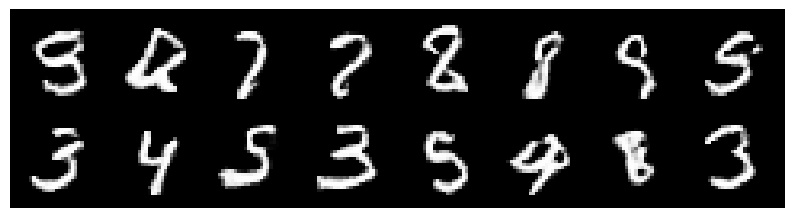

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.751, loss_G=1.74]


Epoch [17/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [17/100] - Average D loss: 0.7340, Average G loss: 1.8365


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.904, loss_G=1.64]


Epoch [18/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [18/100] - Average D loss: 0.7156, Average G loss: 1.8789


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=1.04, loss_G=1.46]


Epoch [19/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [19/100] - Average D loss: 0.7013, Average G loss: 1.9137


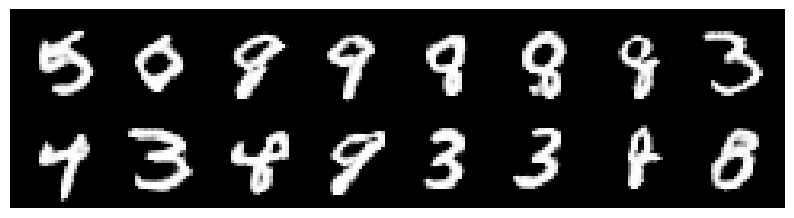

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.955, loss_G=1.57]


Epoch [20/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [20/100] - Average D loss: 0.6934, Average G loss: 1.9224


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.833, loss_G=1.94]


Epoch [21/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [21/100] - Average D loss: 0.6780, Average G loss: 1.9460


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.884, loss_G=2.54]

Epoch [22/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [22/100] - Average D loss: 0.6650, Average G loss: 1.9935


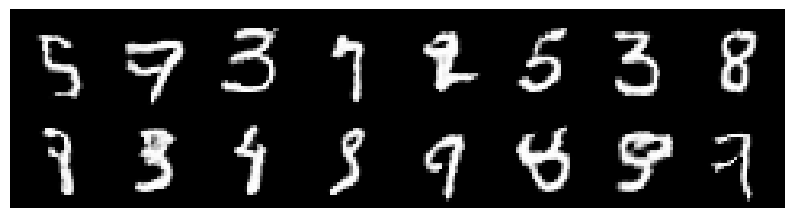

100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.806, loss_G=2.5]


Epoch [23/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [23/100] - Average D loss: 0.6564, Average G loss: 2.0368


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.776, loss_G=2.69]


Epoch [24/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [24/100] - Average D loss: 0.6532, Average G loss: 2.0335


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.748, loss_G=1.41]


Epoch [25/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [25/100] - Average D loss: 0.6489, Average G loss: 2.0595


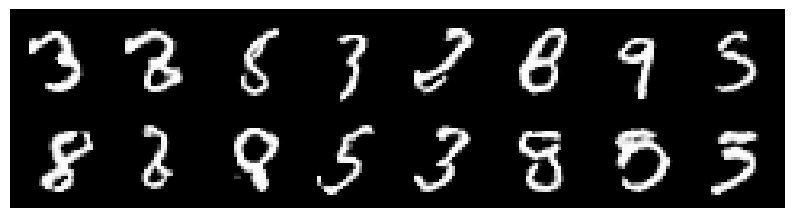

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.564, loss_G=1.52]


Epoch [26/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [26/100] - Average D loss: 0.6407, Average G loss: 2.0780


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.671, loss_G=2.22]


Epoch [27/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [27/100] - Average D loss: 0.6351, Average G loss: 2.0922


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.71, loss_G=1.78]


Epoch [28/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [28/100] - Average D loss: 0.6332, Average G loss: 2.0932


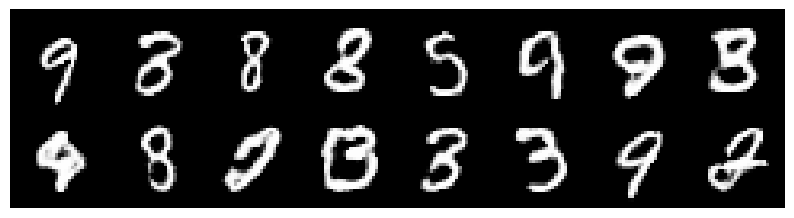

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.605, loss_G=3.46]


Epoch [29/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [29/100] - Average D loss: 0.6255, Average G loss: 2.1155


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.268, loss_G=2.48]


Epoch [30/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [30/100] - Average D loss: 0.6273, Average G loss: 2.1137


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.693, loss_G=2.09]


Epoch [31/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [31/100] - Average D loss: 0.6208, Average G loss: 2.1294


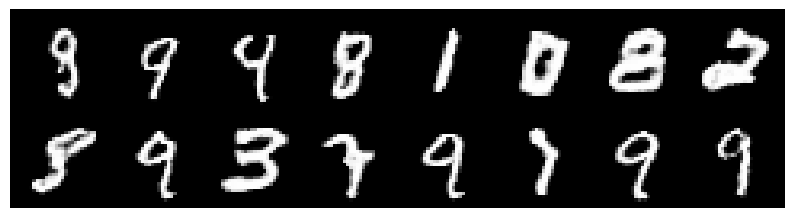

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.337, loss_G=2.37]


Epoch [32/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [32/100] - Average D loss: 0.6123, Average G loss: 2.1346


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.21it/s, loss_D=0.42, loss_G=2.46]


Epoch [33/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [33/100] - Average D loss: 0.6164, Average G loss: 2.1309


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.826, loss_G=2.07]


Epoch [34/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [34/100] - Average D loss: 0.6112, Average G loss: 2.1400


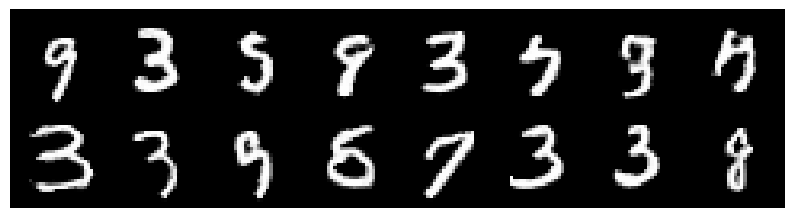

100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.65, loss_G=2.43]


Epoch [35/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [35/100] - Average D loss: 0.6146, Average G loss: 2.1463


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.574, loss_G=2.45]


Epoch [36/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [36/100] - Average D loss: 0.6076, Average G loss: 2.1565


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.19it/s, loss_D=0.318, loss_G=3.16]


Epoch [37/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [37/100] - Average D loss: 0.6048, Average G loss: 2.1788


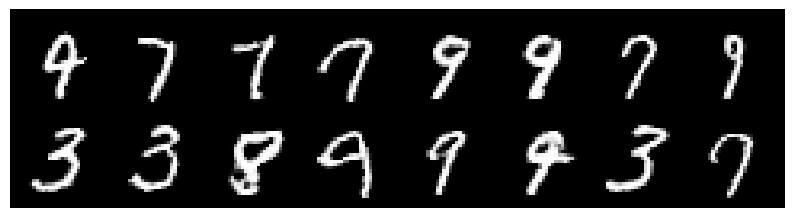

100%|███████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.89, loss_G=1.8]


Epoch [38/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [38/100] - Average D loss: 0.6104, Average G loss: 2.1547


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.612, loss_G=2.89]


Epoch [39/100] - LR G: 0.0001600, LR D: 0.0002000
Epoch [39/100] - Average D loss: 0.6172, Average G loss: 2.1441


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.469, loss_G=2.73]

Epoch [40/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [40/100] - Average D loss: 0.6054, Average G loss: 2.1603


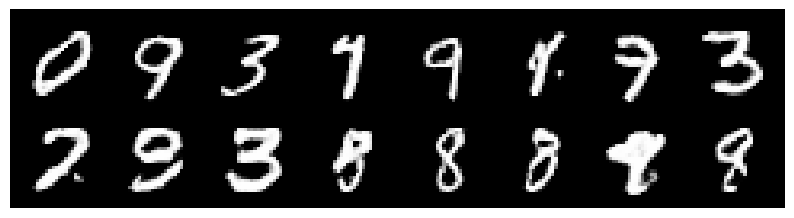

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.711, loss_G=1.61]


Epoch [41/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [41/100] - Average D loss: 0.6057, Average G loss: 2.1461


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.642, loss_G=2.24]


Epoch [42/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [42/100] - Average D loss: 0.6012, Average G loss: 2.1722


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.14it/s, loss_D=0.587, loss_G=2.1]

Epoch [43/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [43/100] - Average D loss: 0.6013, Average G loss: 2.1533


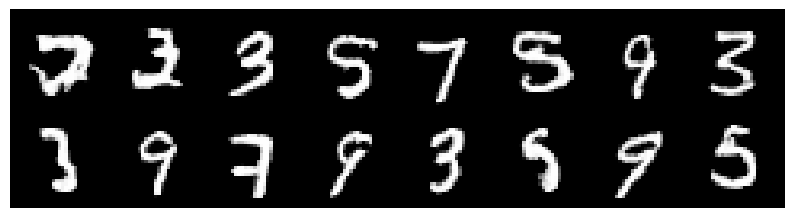

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.769, loss_G=2.29]


Epoch [44/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [44/100] - Average D loss: 0.5939, Average G loss: 2.1848


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.747, loss_G=1.63]


Epoch [45/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [45/100] - Average D loss: 0.5939, Average G loss: 2.1936


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.797, loss_G=1.19]

Epoch [46/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [46/100] - Average D loss: 0.5920, Average G loss: 2.1869


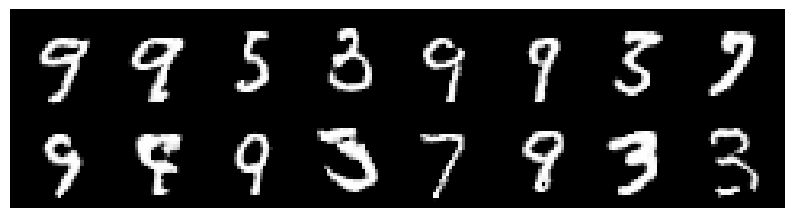

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.307, loss_G=2.57]


Epoch [47/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [47/100] - Average D loss: 0.5793, Average G loss: 2.2379


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.412, loss_G=2.11]


Epoch [48/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [48/100] - Average D loss: 0.5799, Average G loss: 2.2367


100%|█████████████████████████████████████████████████████| 657/657 [01:35<00:00,  6.91it/s, loss_D=0.266, loss_G=2.32]

Epoch [49/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [49/100] - Average D loss: 0.5696, Average G loss: 2.2513


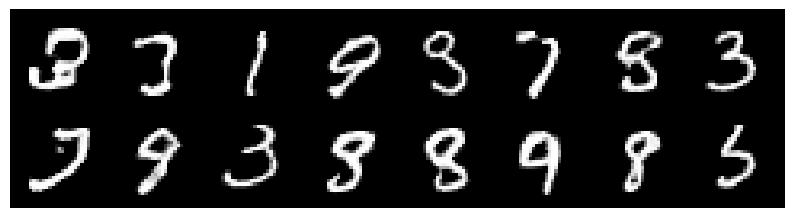

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.321, loss_G=2.59]


Epoch [50/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [50/100] - Average D loss: 0.5686, Average G loss: 2.2763


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.866, loss_G=1.91]


Epoch [51/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [51/100] - Average D loss: 0.5649, Average G loss: 2.2798


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.484, loss_G=2.25]

Epoch [52/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [52/100] - Average D loss: 0.5664, Average G loss: 2.2751


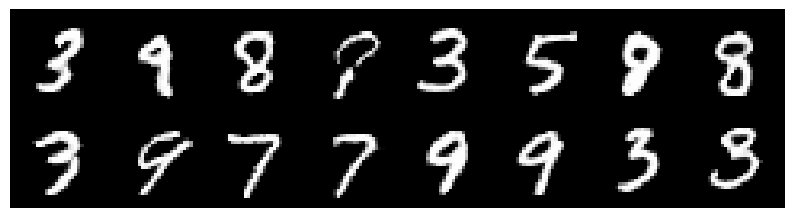

100%|█████████████████████████████████████████████████████| 657/657 [01:35<00:00,  6.90it/s, loss_D=0.619, loss_G=2.17]


Epoch [53/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [53/100] - Average D loss: 0.5604, Average G loss: 2.2984


100%|█████████████████████████████████████████████████████| 657/657 [01:35<00:00,  6.92it/s, loss_D=0.468, loss_G=2.31]


Epoch [54/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [54/100] - Average D loss: 0.5525, Average G loss: 2.3030


100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.2, loss_G=2.56]

Epoch [55/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [55/100] - Average D loss: 0.5544, Average G loss: 2.3239


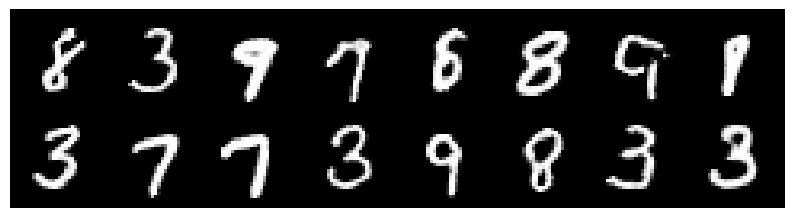

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.403, loss_G=2.51]


Epoch [56/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [56/100] - Average D loss: 0.5507, Average G loss: 2.3311


100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.43, loss_G=2.2]


Epoch [57/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [57/100] - Average D loss: 0.5500, Average G loss: 2.3196


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.479, loss_G=2.29]

Epoch [58/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [58/100] - Average D loss: 0.5613, Average G loss: 2.3380


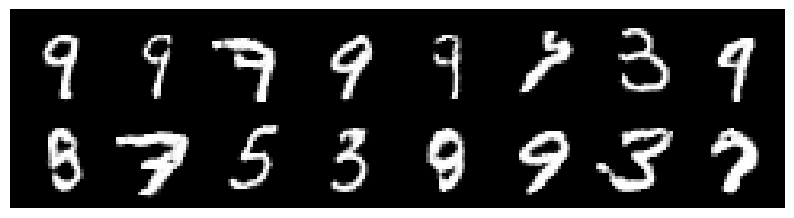

100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.9, loss_G=2.33]


Epoch [59/100] - LR G: 0.0001280, LR D: 0.0002000
Epoch [59/100] - Average D loss: 0.5606, Average G loss: 2.3199


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.642, loss_G=2.44]


Epoch [60/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [60/100] - Average D loss: 0.5477, Average G loss: 2.3577


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.613, loss_G=1.45]

Epoch [61/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [61/100] - Average D loss: 0.5516, Average G loss: 2.3291


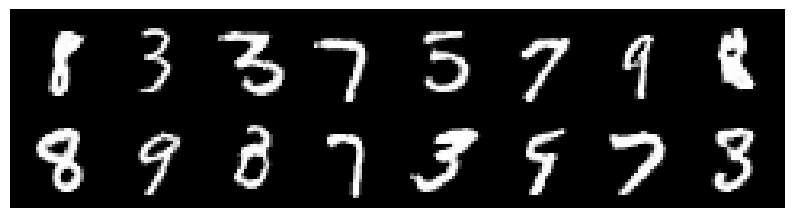

100%|████████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.4, loss_G=2.6]


Epoch [62/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [62/100] - Average D loss: 0.5519, Average G loss: 2.3131


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.961, loss_G=1.95]


Epoch [63/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [63/100] - Average D loss: 0.5414, Average G loss: 2.3606


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.442, loss_G=2.57]

Epoch [64/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [64/100] - Average D loss: 0.5434, Average G loss: 2.3630


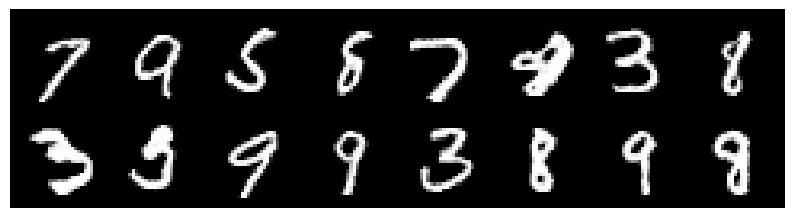

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.684, loss_G=2.35]


Epoch [65/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [65/100] - Average D loss: 0.5371, Average G loss: 2.3979


100%|█████████████████████████████████████████████████████| 657/657 [01:35<00:00,  6.91it/s, loss_D=0.466, loss_G=1.73]


Epoch [66/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [66/100] - Average D loss: 0.4754, Average G loss: 2.5887


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.327, loss_G=2.12]

Epoch [67/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [67/100] - Average D loss: 0.4594, Average G loss: 2.6363


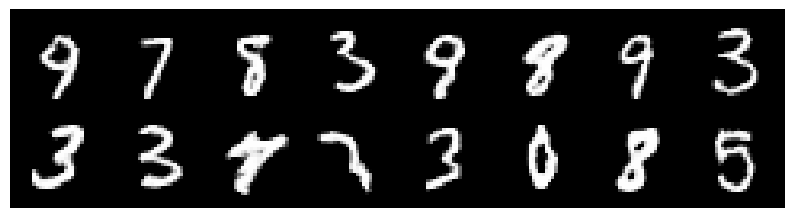

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.199, loss_G=3.32]


Epoch [68/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [68/100] - Average D loss: 0.4944, Average G loss: 2.5383


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.452, loss_G=2.91]


Epoch [69/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [69/100] - Average D loss: 0.5280, Average G loss: 2.4304


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.447, loss_G=2.75]


Epoch [70/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [70/100] - Average D loss: 0.5208, Average G loss: 2.4487


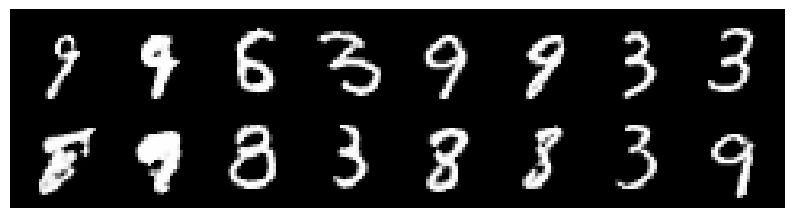

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.523, loss_G=2.23]


Epoch [71/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [71/100] - Average D loss: 0.5203, Average G loss: 2.4355


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.219, loss_G=2.95]


Epoch [72/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [72/100] - Average D loss: 0.5176, Average G loss: 2.4493


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.409, loss_G=3.91]

Epoch [73/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [73/100] - Average D loss: 0.5083, Average G loss: 2.5032


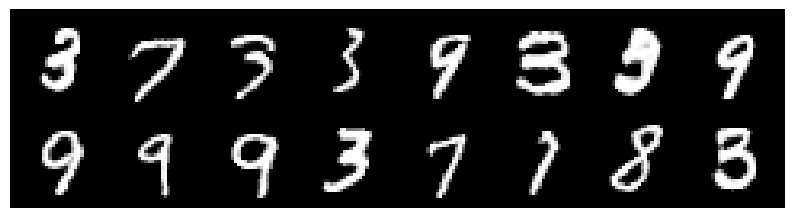

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.219, loss_G=3.56]


Epoch [74/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [74/100] - Average D loss: 0.5082, Average G loss: 2.4849


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.248, loss_G=3.88]


Epoch [75/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [75/100] - Average D loss: 0.5056, Average G loss: 2.5128


100%|█████████████████████████████████████████████████████| 657/657 [01:36<00:00,  6.80it/s, loss_D=0.632, loss_G=2.34]

Epoch [76/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [76/100] - Average D loss: 0.5015, Average G loss: 2.5213


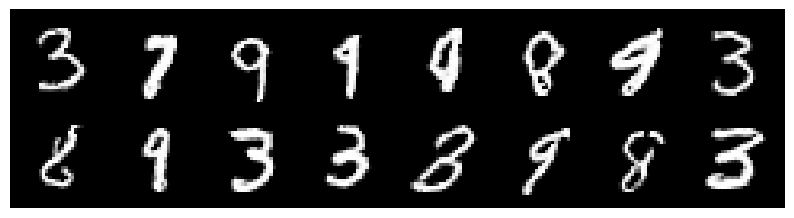

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.643, loss_G=2.25]


Epoch [77/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [77/100] - Average D loss: 0.4917, Average G loss: 2.5755


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.206, loss_G=2.76]


Epoch [78/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [78/100] - Average D loss: 0.4869, Average G loss: 2.5858


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.248, loss_G=4.16]

Epoch [79/100] - LR G: 0.0001024, LR D: 0.0002000
Epoch [79/100] - Average D loss: 0.4858, Average G loss: 2.5877


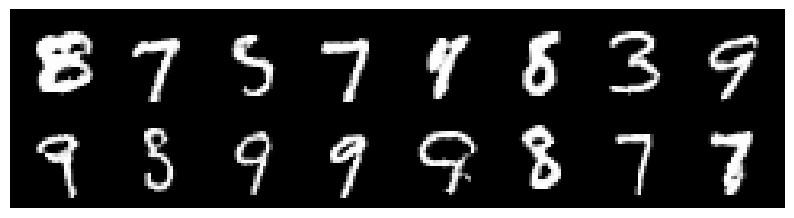

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.622, loss_G=3.65]


Epoch [80/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [80/100] - Average D loss: 0.4789, Average G loss: 2.6239


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.237, loss_G=2.93]


Epoch [81/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [81/100] - Average D loss: 0.4918, Average G loss: 2.5706


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.564, loss_G=2.58]

Epoch [82/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [82/100] - Average D loss: 0.4839, Average G loss: 2.5859


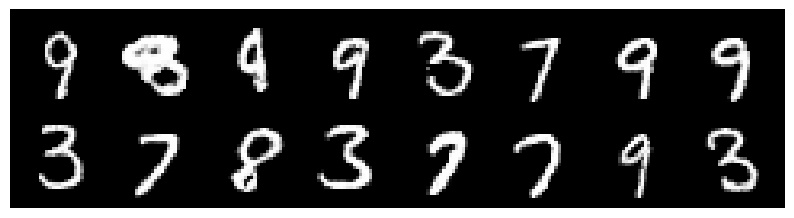

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.547, loss_G=3.03]


Epoch [83/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [83/100] - Average D loss: 0.4805, Average G loss: 2.5976


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.255, loss_G=2.43]


Epoch [84/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [84/100] - Average D loss: 0.4782, Average G loss: 2.6329


100%|████████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.196, loss_G=3]

Epoch [85/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [85/100] - Average D loss: 0.4744, Average G loss: 2.6400


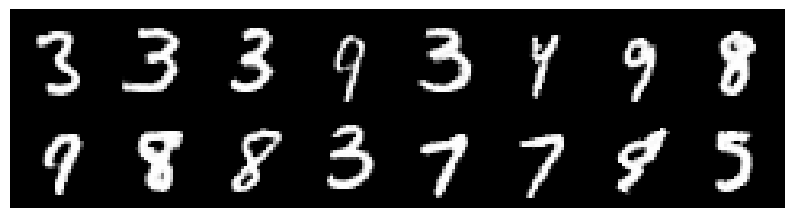

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.525, loss_G=2.82]


Epoch [86/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [86/100] - Average D loss: 0.4666, Average G loss: 2.6694


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.447, loss_G=3.67]


Epoch [87/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [87/100] - Average D loss: 0.4642, Average G loss: 2.6926


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.44, loss_G=1.93]

Epoch [88/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [88/100] - Average D loss: 0.4674, Average G loss: 2.6842


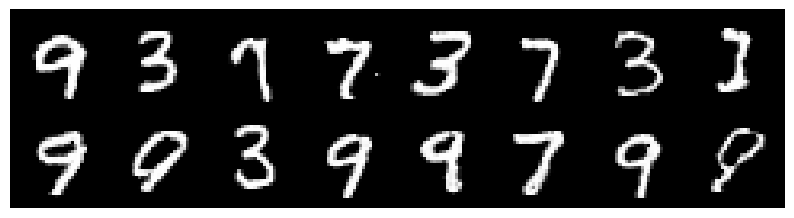

100%|█████████████████████████████████████████████████████| 657/657 [01:35<00:00,  6.91it/s, loss_D=0.391, loss_G=2.65]


Epoch [89/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [89/100] - Average D loss: 0.4493, Average G loss: 2.7513


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.44, loss_G=3.57]


Epoch [90/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [90/100] - Average D loss: 0.4536, Average G loss: 2.7437


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.193, loss_G=2.95]

Epoch [91/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [91/100] - Average D loss: 0.4516, Average G loss: 2.7755


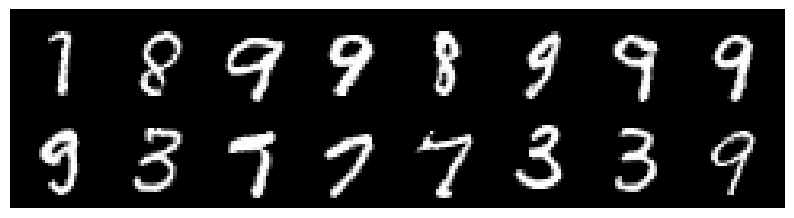

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.182, loss_G=3.75]


Epoch [92/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [92/100] - Average D loss: 0.4460, Average G loss: 2.7729


100%|██████████████████████████████████████████████████████| 657/657 [01:20<00:00,  8.13it/s, loss_D=0.34, loss_G=2.31]


Epoch [93/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [93/100] - Average D loss: 0.4673, Average G loss: 2.7144


100%|███████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.56, loss_G=1.6]

Epoch [94/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [94/100] - Average D loss: 0.4415, Average G loss: 2.7733


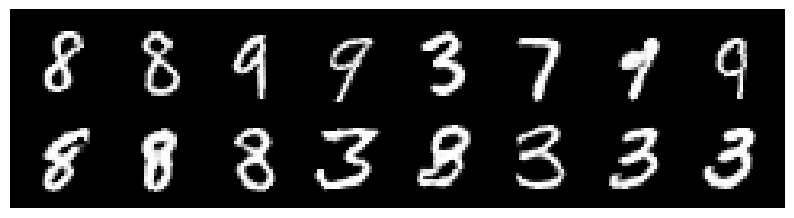

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.398, loss_G=3.36]


Epoch [95/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [95/100] - Average D loss: 0.4369, Average G loss: 2.8257


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=0.517, loss_G=2.92]


Epoch [96/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [96/100] - Average D loss: 0.4379, Average G loss: 2.8401


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.424, loss_G=2.45]


Epoch [97/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [97/100] - Average D loss: 0.4343, Average G loss: 2.8430


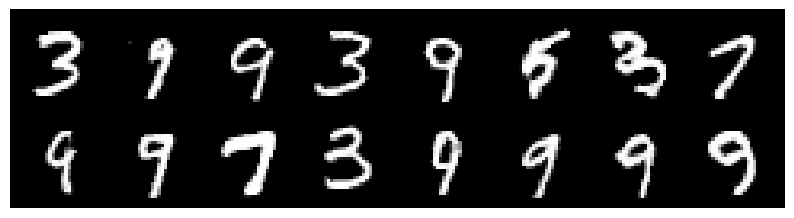

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=0.172, loss_G=3.55]


Epoch [98/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [98/100] - Average D loss: 0.4259, Average G loss: 2.8962


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.257, loss_G=4.41]


Epoch [99/100] - LR G: 0.0000819, LR D: 0.0002000
Epoch [99/100] - Average D loss: 0.4271, Average G loss: 2.9009


100%|████████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=0.449, loss_G=2]


Epoch [100/100] - LR G: 0.0000655, LR D: 0.0002000
Epoch [100/100] - Average D loss: 0.4209, Average G loss: 2.9325


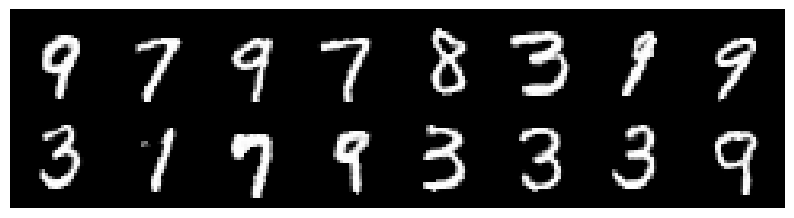

In [13]:
def preprocess_images(images):
    return images.float() * 255.0

# Initialize variables
min_g_loss = float('inf')
epochs = 100
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    # scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8, normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator1.pth')

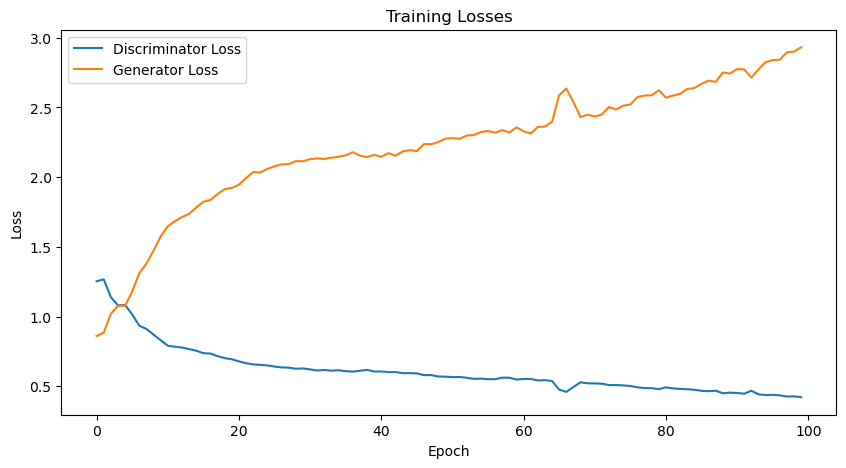

In [14]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [16]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [17]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator1.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

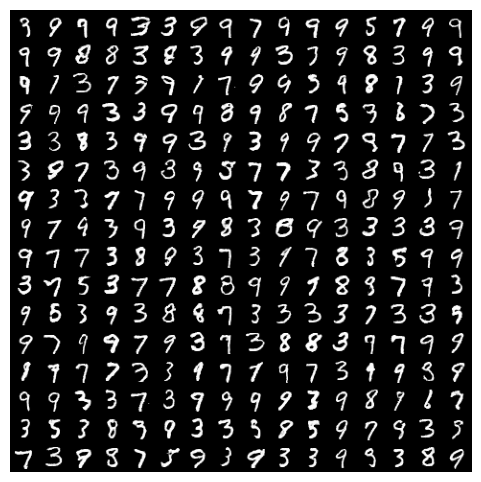

In [18]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
